In [111]:
import torch
import random
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from torch.optim  import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [2]:
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
model_path = "/kaggle/input/wikinews300d1msubwordvec/wiki-news-300d-1M-subword.vec"
fasttext_model = KeyedVectors.load_word2vec_format(model_path)

In [4]:
df = pd.read_csv('/kaggle/input/stocknews/Combined_News_DJIA.csv')
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [5]:
def process_text(text, stemmer, stop_words):
    if not isinstance(text, str):
        return None
    tokens = word_tokenize(text.lower())
    # filtered_tokens = [t for t in tokens if t.isalpha() and t not in stop_words]  
    stemmed_tokens = [stemmer.stem(t) for t in tokens]
    return stemmed_tokens

def vectorize(tokens, fasttext_model, PAD_VECTOR, MAX_LEN):
    vectors = []
    mask = []
    for t in tokens[:MAX_LEN]:
        if t in fasttext_model:
            vectors.append(fasttext_model[t])
        else:
            vectors.append(PAD_VECTOR)
        mask.append(1) 

    while len(vectors) < MAX_LEN:
        vectors.append(PAD_VECTOR)
        mask.append(0) 

    return np.stack(vectors), np.array(mask)

In [6]:
def combine_embeddings(df, fasttext_model, num_news=1, MAX_LEN=32, EMBEDDING_DIM=300):
    news, labels, masks = [], [], []

    stop_words = set(stopwords.words('english'))
    PAD_VECTOR = np.zeros(EMBEDDING_DIM)
    num_news = 2 + num_news
    stemmer = PorterStemmer()
    
    for _, row in df.iterrows():
        day_news, day_mask = [], []
        for idx in range(2, num_news):
            text = row[idx]
            tokens = process_text(text, stemmer, stop_words)
        
            if tokens is None or len(tokens) == 0:
                continue
        
            embeddings, mask = vectorize(tokens, fasttext_model, PAD_VECTOR, MAX_LEN)
            day_news.extend(embeddings) 
            day_mask.extend(mask)
            
        news.append(np.array(day_news))
        labels.append(row[1])
        masks.append(np.array(day_mask))
    return (np.array(news), np.array(labels), np.array(masks))

In [54]:
def prepare_dataloaders(news, masks, labels, batch_size=64, test_size=0.1, val_size=0.1):
    
    encoder = LabelEncoder()
    labels_encoded = encoder.fit_transform(labels)

    X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
        news, labels_encoded, masks, test_size=test_size, random_state=42)

    X_train, X_val, y_train, y_val, masks_train, masks_val = train_test_split(
        X_train, y_train, masks_train, test_size=val_size, random_state=42)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

    def to_tensor(data, dtype):
        return torch.tensor(data, dtype=dtype)

    X_train_tensor = to_tensor(X_train, torch.float32)
    y_train_tensor = to_tensor(y_train, torch.long)
    masks_train_tensor = to_tensor(masks_train, torch.bool)

    X_val_tensor = to_tensor(X_val, torch.float32)
    y_val_tensor = to_tensor(y_val, torch.long)
    masks_val_tensor = to_tensor(masks_val, torch.bool)

    X_test_tensor = to_tensor(X_test, torch.float32)
    y_test_tensor = to_tensor(y_test, torch.long)
    masks_test_tensor = to_tensor(masks_test, torch.bool)

    train_dataset = TensorDataset(X_train_tensor, masks_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, masks_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, masks_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=Tru)
    return train_loader, val_loader, test_loader, class_weights_tensor, encoder

In [8]:
def seed_everything(seed_value=0):
    random.seed(seed_value)  
    np.random.seed(seed_value)  
    torch.manual_seed(seed_value) 
    torch.cuda.manual_seed(seed_value) 
    torch.cuda.manual_seed_all(seed_value) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, drop_prob, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.dropout = nn.Dropout(drop_prob)
        self.batchnorm = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        out = self.conv(x)
        out = self.dropout(out)
        out = self.batchnorm(out)
        out = F.relu(out)
        return out


class FractalBlock(nn.Module):
    def __init__(self, n_columns, input_channels, output_channels, kernel_size, local_drop_prob, dropout_prob,
                 global_drop_prob, training=True):
        super().__init__()
        self.n_columns = n_columns
        self.columns = nn.ModuleList([nn.ModuleList() for _ in range(n_columns)])
        self.max_depth = 2 ** (n_columns - 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob
        self.count = np.zeros([self.max_depth], dtype=int)
        dist = self.max_depth
        for col in self.columns:
            for i in range(self.max_depth):
                if (i + 1) % dist == 0:
                    first_block = (i + 1 == dist)
                    if first_block:
                        cur_input = input_channels
                    else:
                        cur_input = output_channels

                    module = ConvBlock(cur_input, output_channels, kernel_size, dropout_prob)
                    self.count[i] += 1
                else:
                    module = None
                col.append(module)
            dist //= 2

    def drop_mask(self, B, global_cols, n_cols):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if isinstance(global_cols, np.ndarray):
            global_cols = torch.tensor(global_cols, device=device)
        
        GB = global_cols.shape[0]
        gdrop_cols = global_cols - (self.n_columns - n_cols)
        gdrop_indices = torch.where(gdrop_cols >= 0)[0]
        
        gdrop_mask = torch.zeros(n_cols, GB, device=device, dtype=torch.float32)
        if gdrop_indices.shape[0] > 0:
            gdrop_mask[gdrop_cols[gdrop_indices], gdrop_indices] = 1.0
            
        LB = B - GB
        prob_tensor = torch.ones(n_cols, LB, device=device) * (1. - self.local_drop_prob)
        ldrop_mask = torch.bernoulli(prob_tensor)
        alive_count = ldrop_mask.sum(dim=0)
        
        dead_indices = torch.where(alive_count == 0.)[0]
        if dead_indices.shape[0] > 0:
            random_rows = torch.randint(0, n_cols, (dead_indices.shape[0],), device=device)
            ldrop_mask[random_rows, dead_indices] = 1.0
        drop_mask = torch.cat((gdrop_mask, ldrop_mask), dim=1)
        return drop_mask

    def join(self, outs, global_cols):
        n_cols = len(outs)
        out = torch.stack(outs) 

        if self.training:
            mask = self.drop_mask(out.size(1), global_cols, n_cols).to(out.device)  # [n_cols, B]
            mask = mask.view(*mask.size(), 1, 1) 
            n_alive = mask.sum(dim=0)  
            masked_out = out * mask  
            n_alive[n_alive == 0.] = 1.
            out = masked_out.sum(dim=0) / n_alive  
        else:
            out = out.mean(dim=0)
        return out

    def forward(self, x, global_cols):
        outs = [x] * self.n_columns
        for i in range(self.max_depth):
            st = self.n_columns - self.count[i]
            cur_outs = []

            for c in range(st, self.n_columns):
                cur_in = outs[c]
                cur_module = self.columns[c][i]
                if cur_module is not None:
                    cur_outs.append(cur_module(cur_in))

            joined = self.join(cur_outs, global_cols)

            for c in range(st, self.n_columns):
                outs[c] = joined

        outs[-1] = self.dropout(outs[-1])
        return outs[-1]

class FractalNet(nn.Module):
    def __init__(self, n_blocks, n_columns, out_channels, kernel_size, local_drop_prob, drop_prob,
                 global_drop_prob, embedding_dim):
        super().__init__()
        self.n_blocks = n_blocks
        self.n_columns = n_columns
        self.out_channels = out_channels
        self.local_drop_prob = local_drop_prob
        self.global_drop_prob = global_drop_prob

        self.layers = nn.ModuleList()
        total_layers = 0

        current_channels = embedding_dim
        for i in range(self.n_blocks):
            print(f"Block {i + 1}, Input channels: {current_channels}, Output channels: {out_channels[i]}")
            fractal_block = FractalBlock(n_columns, current_channels, out_channels[i], kernel_size,
                                         local_drop_prob, drop_prob, global_drop_prob)
            self.layers.append(fractal_block)
            self.layers.append(nn.BatchNorm1d(out_channels[i]))
            current_channels = out_channels[i]
            total_layers += fractal_block.max_depth

        self.initialize_weights()
        print(f"Total layers in network: {total_layers}")

    def initialize_weights(self):
        for name, param in self.named_parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
            else:
                if 'bn.weight' in name:
                    nn.init.ones_(param)
                elif 'bn.bias' in name or 'bias' in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        B, T, E = x.shape             
        x = x.permute(0, 2, 1)  

        GB = int(x.size(0) * self.global_drop_prob)
        global_cols = None

        out = x
        for layer in self.layers:
            if isinstance(layer, FractalBlock):
                global_cols = np.random.randint(0, self.n_columns, size=[GB])
                out = layer(out, global_cols)  
            else:
                out = layer(out)              

        out = out.permute(0, 2, 1)
        return out

In [10]:
class NewsAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=1, dropout=0.1):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads,
                                          dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
    
        key_padding_mask = ~mask
        attn_output, attn_weights = self.attn(x, x, x, key_padding_mask=key_padding_mask)
        out = self.norm(x + self.dropout(attn_output))
        pooled = out.mean(dim=1)
        return pooled, attn_weights

In [18]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=(1024, 512), dropout=0.3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], 2)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) 
        return x

In [48]:
class NewsModel(nn.Module):
    def __init__(self, embedding_dim, n_blocks, n_columns, out_channels, kernel_size, 
                 local_drop_prob, drop_prob, global_drop_prob, mlp_hidden_dims, dropout):
        super().__init__()
        
        self.fractal_net = FractalNet(
            n_blocks=n_blocks,
            n_columns=n_columns,
            out_channels=out_channels,
            kernel_size=kernel_size,
            local_drop_prob=local_drop_prob,
            drop_prob=drop_prob,
            global_drop_prob=global_drop_prob,
            embedding_dim=embedding_dim
        )
        
        fractal_output_dim = out_channels[-1]
        
        self.attention = NewsAttention(
            embed_dim=fractal_output_dim,
            num_heads=1, 
            dropout=dropout
        )
        
        self.classifier = Classifier(
            input_dim=fractal_output_dim,
            hidden_dims=mlp_hidden_dims,
            dropout=dropout
        )
        
    def forward(self, x, mask):
        fractal_output = self.fractal_net(x) 
        attention_output, attention_weights = self.attention(fractal_output, mask)
        logits = self.classifier(attention_output)
        return logits

In [13]:
def train(model, train_loader, val_loader, num_epoch, optimizer, criterion, device):
    best_f1 = 0.0
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epoch):
        model.train()
        train_loss = 0.0
        y_true_train = []
        y_pred_train = []

        for batch in train_loader:
            tokens, masks, targets = batch
            tokens = tokens.to(device)
            masks = masks.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(tokens, masks)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * tokens.size(0)

            probs = torch.softmax(outputs, dim=1).detach().cpu().numpy()
            preds = probs.argmax(axis=1)

            y_pred_train.extend(preds)
            y_true_train.extend(targets.cpu().numpy())

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_report = classification_report(y_true_train, y_pred_train, output_dict=True, zero_division=0)

        model.eval()
        val_loss = 0.0
        y_true_val = []
        y_pred_val = []

        with torch.no_grad():
            for batch in val_loader:
                tokens, masks, targets = batch
                tokens = tokens.to(device)
                masks = masks.to(device)
                targets = targets.to(device)

                outputs = model(tokens, masks)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * tokens.size(0)

                probs = torch.softmax(outputs, dim=1).cpu().numpy()
                preds = probs.argmax(axis=1)

                y_pred_val.extend(preds)
                y_true_val.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader.dataset)
        val_report = classification_report(y_true_val, y_pred_val, output_dict=True, zero_division=0)
        val_f1 = val_report['weighted avg']['f1-score']

        if (epoch + 1) % 50 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{num_epoch}:")
            print(f"  Train Precision: {train_report['weighted avg']['precision']:.4f}, "
                  f"Recall: {train_report['weighted avg']['recall']:.4f}, "
                  f"F1: {train_report['weighted avg']['f1-score']:.4f}")
            print(f"  Val Precision: {val_report['weighted avg']['precision']:.4f}, "
                  f"Recall: {val_report['weighted avg']['recall']:.4f}, "
                  f"F1: {val_f1:.4f}")

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return avg_train_loss, train_report, avg_val_loss, val_report

In [14]:
def test_model(model, test_dataloader, device, name):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in test_dataloader:
            tokens, masks, targets = batch
            tokens = tokens.to(device)
            masks = masks.to(device)
            targets = targets.to(device)

            outputs = model(tokens, masks)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            preds = probs.argmax(axis=1)

            y_true.extend(targets.cpu().numpy())
            y_pred.extend(preds)

    report = classification_report(y_true, y_pred, zero_division=0)
    print("Classification Report:\n", report)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig(name, dpi=300, bbox_inches='tight')  
    plt.show()

In [15]:
def validate(model, val_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for tokens, masks, labels in val_loader:
            tokens = tokens.to(device)
            masks = masks.to(device)
            labels = labels.to(device)
            
            outputs = model(tokens, masks) 
            loss = criterion(outputs, labels)
            running_loss += loss.item() * tokens.size(0)

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    val_loss = running_loss / total
    val_accuracy = correct / total
    
    report = classification_report(all_labels, all_preds, digits=4)
    print("Classification Report:\n", report)
    
    return val_loss, val_accuracy, report

In [21]:
n_blocks_choices = [2, 3, 4]
n_columns_choices = [2, 3, 4]
base_out_channels_choices = [
    [16, 32, 64, 128],
    [32, 64, 128, 256],
    [64, 128, 256, 512]
]
local_drop_prob_choices = [0.0, 0.3, 0.5]
drop_prob_choices = [0.0, 0.1, 0.3, 0.4, 0.5]
global_drop_prob_choices = [0.0, 0.1, 0.3, 0.4, 0.5]
dropout_choices = [0.0, 0.1, 0.3]
lr_choices = [1e-5, 1e-4, 1e-3]

def sample_params():
    n_blocks = random.choice(n_blocks_choices)
    n_columns = random.choice(n_columns_choices)
    base_out_channels = random.choice(base_out_channels_choices)
    out_channels = base_out_channels[:n_blocks]

    return {
        'n_blocks': n_blocks,
        'n_columns': n_columns,
        'out_channels': out_channels,
        'local_drop_prob': random.choice(local_drop_prob_choices),
        'drop_prob': random.choice(drop_prob_choices),
        'global_drop_prob': random.choice(global_drop_prob_choices),
        'dropout': random.choice(dropout_choices),
        'lr': random.choice(lr_choices),
        'kernel_size': 3,
        'embedding_dim': 300
    }

best_accuracy = 0
best_params = None
num_trials = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for trial in range(num_trials):
    params = sample_params()
    print(f"Trial {trial+1}/{num_trials}: {params}")

    model = NewsModel(
        embedding_dim=params['embedding_dim'],
        n_blocks=params['n_blocks'],
        n_columns=params['n_columns'],
        out_channels=params['out_channels'],
        kernel_size=params['kernel_size'],
        local_drop_prob=params['local_drop_prob'],
        drop_prob=params['drop_prob'],
        global_drop_prob=params['global_drop_prob'],
        mlp_hidden_dims=[128, 128],
        dropout=params['dropout'],
    ).to(device)

    news, labels, masks = combine_embeddings(df, fasttext_model, 3, 64)
    train_loader, val_loader, test_loader, class_weights, encoder = prepare_dataloaders(news, masks, labels)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'])
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    train(model, train_loader, val_loader, num_epoch=100, optimizer=optimizer,
          criterion=criterion, device=device) 

    val_loss, val_accuracy, report = validate(model, val_loader, criterion, device)

    print(f"Validation accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_params = params

print(f"\nBest accuracy: {best_accuracy:.4f}")
print(f"Best params: {best_params}")

Trial 1/20: {'n_blocks': 3, 'n_columns': 4, 'out_channels': [32, 64, 128], 'local_drop_prob': 0.5, 'drop_prob': 0.5, 'global_drop_prob': 0.5, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Total layers in network: 24


/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/100:
  Train Precision: 0.5047, Recall: 0.5115, F1: 0.4994
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.5000, Recall: 0.5140, F1: 0.4728
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 100/100:
  Train Precision: 0.4832, Recall: 0.4724, F1: 0.3438
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 2/20: {'n_blocks': 3, 'n_columns': 2, 'out_channels': [64, 128, 256], 'local_drop_prob': 0.3, 'drop_prob': 0.0, 'global_drop_prob': 0.5, 'dropout': 0.1, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4995, Recall: 0.4978, F1: 0.4982
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.8853, Recall: 0.8845, F1: 0.8846
  Val Precision: 0.5277, Recall: 0.4804, F1: 0.4644
Epoch 100/100:
  Train Precision: 0.9814, Recall: 0.9814, F1: 0.9814
  Val Precision: 0.5243, Recall: 0.5251, F1: 0.5247
Classification Report:
               precision    recall  f1-score   support

           0     0.4324    0.4267    0.4295        75
           1     0.5905    0.5962    0.5933       104

    accuracy                         0.5251       179
   macro avg     0.5115    0.5114    0.5114       179
weighted avg     0.5243    0.5251    0.5247       179

Validation accuracy: 0.5251
Trial 3/20: {'n_blocks': 3, 'n_columns': 2, 'out_channels': [32, 64, 128], 'local_drop_prob': 0.3, 'drop_prob': 0.4, 'global_drop_prob': 0.1, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 32


/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/100:
  Train Precision: 0.5224, Recall: 0.5239, F1: 0.5227
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.5785, Recall: 0.5568, F1: 0.5432
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.8336, Recall: 0.8324, F1: 0.8325
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 4/20: {'n_blocks': 2, 'n_columns': 3, 'out_channels': [16, 32], 'local_drop_prob': 0.3, 'drop_prob': 0.3, 'global_drop_prob': 0.1, 'dropout': 0.0, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Block

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.7513, Recall: 0.4755, F1: 0.3092
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.4898, Recall: 0.4873, F1: 0.4874
  Val Precision: 0.4481, Recall: 0.4190, F1: 0.4090
Epoch 100/100:
  Train Precision: 0.5034, Recall: 0.5071, F1: 0.5027
  Val Precision: 0.5394, Recall: 0.5642, F1: 0.5310
Classification Report:
               precision    recall  f1-score   support

           0     0.4634    0.2533    0.3276        75
           1     0.5942    0.7885    0.6777       104

    accuracy                         0.5642       179
   macro avg     0.5288    0.5209    0.5026       179
weighted avg     0.5394    0.5642    0.5310       179

Validation accuracy: 0.5642
Trial 5/20: {'n_blocks': 2, 'n_columns': 4, 'out_channels': [32, 64], 'local_drop_prob': 0.3, 'drop_prob': 0.1, 'global_drop_prob': 0.0, 'dropout': 0.3, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 32
Block

/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/100:
  Train Precision: 0.4882, Recall: 0.4879, F1: 0.4880
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.4948, Recall: 0.4922, F1: 0.4924
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.4959, Recall: 0.4978, F1: 0.4963
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 6/20: {'n_blocks': 3, 'n_columns': 2, 'out_channels': [32, 64, 128], 'local_drop_prob': 0.5, 'drop_prob': 0.3, 'global_drop_prob': 0.1, 'dropout': 0.3, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 32

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4605, Recall: 0.4556, F1: 0.4316
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.4973, Recall: 0.5102, F1: 0.4779
  Val Precision: 0.7575, Recall: 0.4246, F1: 0.2595
Epoch 100/100:
  Train Precision: 0.5067, Recall: 0.5016, F1: 0.4997
  Val Precision: 0.5251, Recall: 0.5363, F1: 0.5280
Classification Report:
               precision    recall  f1-score   support

           0     0.4355    0.3600    0.3942        75
           1     0.5897    0.6635    0.6244       104

    accuracy                         0.5363       179
   macro avg     0.5126    0.5117    0.5093       179
weighted avg     0.5251    0.5363    0.5280       179

Validation accuracy: 0.5363
Trial 7/20: {'n_blocks': 2, 'n_columns': 4, 'out_channels': [64, 128], 'local_drop_prob': 0.5, 'drop_prob': 0.3, 'global_drop_prob': 0.0, 'dropout': 0.0, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 64
Bloc

/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/100:
  Train Precision: 0.4722, Recall: 0.4755, F1: 0.4726
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.5254, Recall: 0.5245, F1: 0.5248
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.5493, Recall: 0.5382, F1: 0.5320
  Val Precision: 0.4842, Recall: 0.5587, F1: 0.4575
Classification Report:
               precision    recall  f1-score   support

           0     0.3571    0.0667    0.1124        75
           1     0.5758    0.9135    0.7063       104

    accuracy                         0.5587       179
   macro avg     0.4665    0.4901    0.4093       179
weighted avg     0.4842    0.5587    0.4575       179

Validation accuracy: 0.5587
Trial 8/20: {'n_blocks': 2, 'n_columns': 4, 'out_channels': [16, 32], 'local_drop_prob': 0.5, 'drop_prob': 0.5, 'global_drop_prob': 0.0, 'dropout': 0.0, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Bloc

/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/100:
  Train Precision: 0.5200, Recall: 0.4966, F1: 0.4527
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.4923, Recall: 0.4960, F1: 0.4921
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.5131, Recall: 0.5251, F1: 0.4559
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 9/20: {'n_blocks': 4, 'n_columns': 2, 'out_channels': [32, 64, 128, 256], 'local_drop_prob': 0.5, 'drop_prob': 0.1, 'global_drop_prob': 0.0, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4960, Recall: 0.4947, F1: 0.4951
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.5040, Recall: 0.5022, F1: 0.5025
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 100/100:
  Train Precision: 0.4851, Recall: 0.4891, F1: 0.4850
  Val Precision: 0.5084, Recall: 0.5084, F1: 0.5084
Classification Report:
               precision    recall  f1-score   support

           0     0.4133    0.4133    0.4133        75
           1     0.5769    0.5769    0.5769       104

    accuracy                         0.5084       179
   macro avg     0.4951    0.4951    0.4951       179
weighted avg     0.5084    0.5084    0.5084       179

Validation accuracy: 0.5084
Trial 10/20: {'n_blocks': 4, 'n_columns': 2, 'out_channels': [64, 128, 256, 512], 'local_drop_prob': 0.5, 'drop_prob': 0.3, 'global_drop_prob': 0.3, 'dropout': 0.0, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channe

/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/100:
  Train Precision: 0.4860, Recall: 0.4730, F1: 0.3678
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.4808, Recall: 0.4786, F1: 0.4788
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 100/100:
  Train Precision: 0.4917, Recall: 0.4836, F1: 0.4736
  Val Precision: 0.4986, Recall: 0.5587, F1: 0.4709
Classification Report:
               precision    recall  f1-score   support

           0     0.3889    0.0933    0.1505        75
           1     0.5776    0.8942    0.7019       104

    accuracy                         0.5587       179
   macro avg     0.4833    0.4938    0.4262       179
weighted avg     0.4986    0.5587    0.4709       179

Validation accuracy: 0.5587
Trial 11/20: {'n_blocks': 3, 'n_columns': 4, 'out_channels': [16, 32, 64], 'local_drop_prob': 0.3, 'drop_prob': 0.3, 'global_drop_prob': 0.0, 'dropout': 0.1, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16


/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/100:
  Train Precision: 0.2777, Recall: 0.5270, F1: 0.3638
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.4995, Recall: 0.5102, F1: 0.4854
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.5152, Recall: 0.5220, F1: 0.5058
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 12/20: {'n_blocks': 2, 'n_columns': 4, 'out_channels': [16, 32], 'local_drop_prob': 0.3, 'drop_prob': 0.3, 'global_drop_prob': 0.3, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16
Bloc

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4739, Recall: 0.4724, F1: 0.4728
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.4575, Recall: 0.4718, F1: 0.3118
  Val Precision: 0.5589, Recall: 0.4581, F1: 0.3803
Epoch 100/100:
  Train Precision: 0.5050, Recall: 0.5084, F1: 0.5047
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Classification Report:
               precision    recall  f1-score   support

           0     0.4190    1.0000    0.5906        75
           1     0.0000    0.0000    0.0000       104

    accuracy                         0.4190       179
   macro avg     0.2095    0.5000    0.2953       179
weighted avg     0.1756    0.4190    0.2474       179

Validation accuracy: 0.4190
Trial 13/20: {'n_blocks': 4, 'n_columns': 3, 'out_channels': [16, 32, 64, 128], 'local_drop_prob': 0.0, 'drop_prob': 0.1, 'global_drop_prob': 0.0, 'dropout': 0.0, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channel

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4822, Recall: 0.4848, F1: 0.4826
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.7975, Recall: 0.7976, F1: 0.7975
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.9442, Recall: 0.9441, F1: 0.9441
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 14/20: {'n_blocks': 3, 'n_columns': 3, 'out_channels': [16, 32, 64], 'local_drop_prob': 0.5, 'drop_prob': 0.3, 'global_drop_prob': 0.1, 'dropout': 0.3, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4663, Recall: 0.5239, F1: 0.3730
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.5136, Recall: 0.5171, F1: 0.5127
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.5180, Recall: 0.5127, F1: 0.5111
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 15/20: {'n_blocks': 4, 'n_columns': 3, 'out_channels': [32, 64, 128, 256], 'local_drop_prob': 0.5, 'drop_prob': 0.4, 'global_drop_prob': 0.4, 'dropout': 0.3, 'lr': 0.0001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channe

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.5146, Recall: 0.5102, F1: 0.5093
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.4953, Recall: 0.4904, F1: 0.4885
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.5025, Recall: 0.5028, F1: 0.5026
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 16/20: {'n_blocks': 4, 'n_columns': 3, 'out_channels': [64, 128, 256, 512], 'local_drop_prob': 0.5, 'drop_prob': 0.1, 'global_drop_prob': 0.4, 'dropout': 0.0, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channe

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4915, Recall: 0.5071, F1: 0.4688
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.5108, Recall: 0.5158, F1: 0.5078
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 100/100:
  Train Precision: 0.5133, Recall: 0.5152, F1: 0.5136
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 17/20: {'n_blocks': 4, 'n_columns': 2, 'out_channels': [32, 64, 128, 256], 'local_drop_prob': 0.5, 'drop_prob': 0.4, 'global_drop_prob': 0.3, 'dropout': 0.0, 'lr': 1e-05, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channel

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.2237, Recall: 0.4730, F1: 0.3038
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.5053, Recall: 0.5003, F1: 0.4987
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 100/100:
  Train Precision: 0.5294, Recall: 0.5196, F1: 0.5130
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Classification Report:
               precision    recall  f1-score   support

           0     0.4190    1.0000    0.5906        75
           1     0.0000    0.0000    0.0000       104

    accuracy                         0.4190       179
   macro avg     0.2095    0.5000    0.2953       179
weighted avg     0.1756    0.4190    0.2474       179

Validation accuracy: 0.4190
Trial 18/20: {'n_blocks': 3, 'n_columns': 4, 'out_channels': [64, 128, 256], 'local_drop_prob': 0.5, 'drop_prob': 0.0, 'global_drop_prob': 0.1, 'dropout': 0.3, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 6

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4890, Recall: 0.4891, F1: 0.4891
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/100:
  Train Precision: 0.4877, Recall: 0.4947, F1: 0.4847
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 100/100:
  Train Precision: 0.4879, Recall: 0.4836, F1: 0.4821
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 19/20: {'n_blocks': 3, 'n_columns': 3, 'out_channels': [16, 32, 64], 'local_drop_prob': 0.0, 'drop_prob': 0.5, 'global_drop_prob': 0.1, 'dropout': 0.0, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channels: 16


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.4801, Recall: 0.4711, F1: 0.4424
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.6679, Recall: 0.6214, F1: 0.6037
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 100/100:
  Train Precision: 0.8579, Recall: 0.8572, F1: 0.8573
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810
Trial 20/20: {'n_blocks': 4, 'n_columns': 3, 'out_channels': [32, 64, 128, 256], 'local_drop_prob': 0.0, 'drop_prob': 0.1, 'global_drop_prob': 0.5, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}
Block 1, Input channels: 300, Output channel

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__geti

Epoch 1/100:
  Train Precision: 0.5075, Recall: 0.5078, F1: 0.5076
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Epoch 50/100:
  Train Precision: 0.4962, Recall: 0.5146, F1: 0.4555
  Val Precision: 0.5179, Recall: 0.5642, F1: 0.4866
Epoch 100/100:
  Train Precision: 0.2777, Recall: 0.5270, F1: 0.3638
  Val Precision: 0.3376, Recall: 0.5810, F1: 0.4270
Classification Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        75
           1     0.5810    1.0000    0.7350       104

    accuracy                         0.5810       179
   macro avg     0.2905    0.5000    0.3675       179
weighted avg     0.3376    0.5810    0.4270       179

Validation accuracy: 0.5810

Best accuracy: 0.5810
Best params: {'n_blocks': 3, 'n_columns': 4, 'out_channels': [32, 64, 128], 'local_drop_prob': 0.5, 'drop_prob': 0.5, 'global_drop_prob': 0.5, 'dropout': 0.1, 'lr': 0.001, 'kernel_size': 3, 'embedding_dim': 300}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Block 1, Input channels: 300, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Block 4, Input channels: 128, Output channels: 256
Total layers in network: 8


/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/150:
  Train Precision: 0.5027, Recall: 0.5022, F1: 0.5024
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/150:
  Train Precision: 0.4912, Recall: 0.5016, F1: 0.4822
  Val Precision: 0.3334, Recall: 0.5642, F1: 0.4192
Epoch 100/150:
  Train Precision: 0.5104, Recall: 0.5034, F1: 0.4993
  Val Precision: 0.5329, Recall: 0.5754, F1: 0.4746
Epoch 150/150:
  Train Precision: 0.5261, Recall: 0.5326, F1: 0.4968
  Val Precision: 0.5498, Recall: 0.5810, F1: 0.4707
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.13      0.21        87
           1       0.58      0.93      0.71       112

    accuracy                           0.58       199
   macro avg       0.58      0.53      0.46       199
weighted avg       0.58      0.58      0.49       199



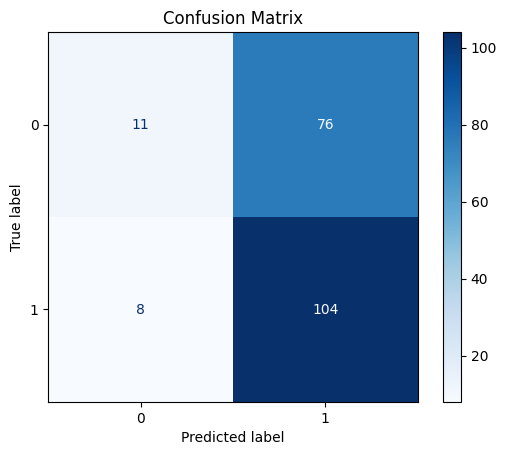

In [56]:
seed_everything(0)
embedding_dim=300
n_blocks= 4
n_columns= 2
out_channels = [32, 64, 128, 256]
kernel_size= 3
local_drop_prob=0.5
drop_prob=0.1
global_drop_prob=0.3
mlp_hidden_dims=[256, 256]
dropout=0.2


num_epoch = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NewsModel(
        embedding_dim=embedding_dim,
        n_blocks=n_blocks,
        n_columns=n_columns,
        out_channels=out_channels,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
        mlp_hidden_dims=mlp_hidden_dims,
        dropout=dropout,
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

news, labels, masks = combine_embeddings(df, fasttext_model, 3, 32)
train_loader, val_loader, test_loader, class_weights, encoder = prepare_dataloaders(news, masks, labels)

train(model, train_loader, val_loader, num_epoch, optimizer=optimizer,
          criterion=criterion, device=device) 

test_model(model, test_loader, device, 'fractal.png')
torch.save(model.state_dict(), 'fractal-attn.pth')

Block 1, Input channels: 300, Output channels: 32
Block 2, Input channels: 32, Output channels: 64
Block 3, Input channels: 64, Output channels: 128
Block 4, Input channels: 128, Output channels: 256
Total layers in network: 8


/tmp/ipykernel_31/3688444839.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  text = row[idx]
/tmp/ipykernel_31/3688444839.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels.append(row[1])


Epoch 1/200:
  Train Precision: 0.5027, Recall: 0.5022, F1: 0.5024
  Val Precision: 0.1756, Recall: 0.4190, F1: 0.2474
Epoch 50/200:
  Train Precision: 0.4912, Recall: 0.5016, F1: 0.4822
  Val Precision: 0.3334, Recall: 0.5642, F1: 0.4192
Epoch 100/200:
  Train Precision: 0.5104, Recall: 0.5034, F1: 0.4993
  Val Precision: 0.5329, Recall: 0.5754, F1: 0.4746
Epoch 150/200:
  Train Precision: 0.5261, Recall: 0.5326, F1: 0.4968
  Val Precision: 0.5498, Recall: 0.5810, F1: 0.4707
Epoch 200/200:
  Train Precision: 0.4954, Recall: 0.5109, F1: 0.4688
  Val Precision: 0.5267, Recall: 0.5196, F1: 0.5221
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.44      0.49        87
           1       0.63      0.73      0.67       112

    accuracy                           0.60       199
   macro avg       0.59      0.58      0.58       199
weighted avg       0.60      0.60      0.59       199



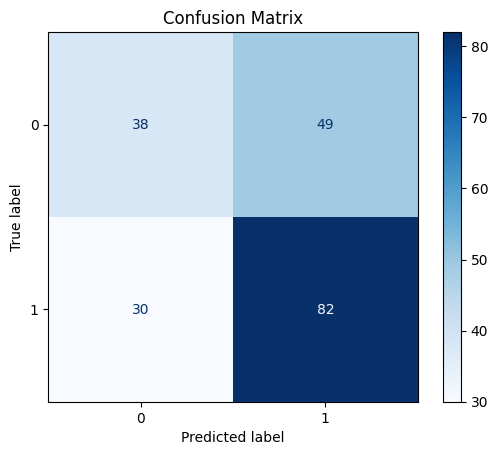

In [57]:
seed_everything(0)
embedding_dim=300
n_blocks= 4
n_columns= 2
out_channels = [32, 64, 128, 256]
kernel_size= 3
local_drop_prob=0.5
drop_prob=0.1
global_drop_prob=0.3
mlp_hidden_dims=[256, 256]
dropout=0.2


num_epoch = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NewsModel(
        embedding_dim=embedding_dim,
        n_blocks=n_blocks,
        n_columns=n_columns,
        out_channels=out_channels,
        kernel_size=kernel_size,
        local_drop_prob=local_drop_prob,
        drop_prob=drop_prob,
        global_drop_prob=global_drop_prob,
        mlp_hidden_dims=mlp_hidden_dims,
        dropout=dropout,
    ).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

news, labels, masks = combine_embeddings(df, fasttext_model, 3, 32)
train_loader, val_loader, test_loader, class_weights, encoder = prepare_dataloaders(news, masks, labels)

train(model, train_loader, val_loader, num_epoch, optimizer=optimizer,
          criterion=criterion, device=device) 

test_model(model, test_loader, device, 'fractal.png')
torch.save(model.state_dict(), 'fractal-attn.pth')

# BERT

In [84]:
df = pd.read_csv('/kaggle/input/stocknews/Combined_News_DJIA.csv')
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [134]:
def prepare_bert_inputs_from_news(df, news_cols, label_col, num_headlines=3, max_len_each=32, batch_size=32, test_size=0.1, val_size=0.1):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    input_ids_list = []
    attention_masks_list = []
    labels_list = []

    for _, row in df.iterrows():
        input_ids_news = []
        attention_masks_news = []
        
        for col in news_cols[:num_headlines]:
            tokens = tokenizer(
                str(row[col]),
                add_special_tokens=True,
                max_length=max_len_each,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            input_ids_news.append(tokens['input_ids'].squeeze(0))
            attention_masks_news.append(tokens['attention_mask'].squeeze(0))
        
        input_ids_combined = torch.cat(input_ids_news)
        attention_masks_combined = torch.cat(attention_masks_news)

        input_ids_list.append(input_ids_combined)
        attention_masks_list.append(attention_masks_combined)
        labels_list.append(row[label_col])

    input_ids = torch.stack(input_ids_list)
    attention_masks = torch.stack(attention_masks_list)
    labels = torch.tensor(labels_list)

    X_temp, X_test, y_temp, y_test, mask_temp, mask_test = train_test_split(
        input_ids, labels, attention_masks, test_size=test_size, random_state=42
    )

    val_ratio = val_size / (1 - test_size)

    X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
        X_temp, y_temp, mask_temp, test_size=val_ratio, random_state=42
    )

    train_data = TensorDataset(X_train, mask_train, y_train)
    val_data = TensorDataset(X_val, mask_val, y_val)
    test_data = TensorDataset(X_test, mask_test, y_test)

    train_loader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)
    val_loader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)
    test_loader = DataLoader(test_data, sampler=SequentialSampler(test_data), batch_size=batch_size)

    return train_loader, val_loader, test_loader


In [135]:
news_columns = [f'Top{i}' for i in range(1, 26)]
train_loader, val_loader, test_loader = prepare_bert_inputs_from_news(
    df=df,
    news_cols=news_columns,
    label_col='Label',
    num_headlines=3,  
    max_len_each=32,    
    batch_size=32
)

In [113]:
num_labels = 2 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [125]:

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1)
    labels_flat = labels
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def train_model(model, train_loader, val_loader, epochs=4, lr=2e-5):
    all_labels = []
    for batch in train_loader:
        _, _, b_labels = batch
        all_labels.extend(b_labels.numpy())
    all_labels = np.array(all_labels)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(all_labels),
        y=all_labels
    )
    weights = torch.tensor(class_weights, dtype=torch.float).to(device)

    
    loss_fct = nn.CrossEntropyLoss(weight=weights)

    optimizer = AdamW(model.parameters(), lr=lr)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

            model.zero_grad()
            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_input_mask,
            )
            logits = outputs.logits

            loss = loss_fct(logits, b_labels)

            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        val_accuracy = 0
        nb_val_steps = 0

        for batch in val_loader:
            b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

            with torch.no_grad():
                outputs = model(
                    input_ids=b_input_ids,
                    attention_mask=b_input_mask
                )
                logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.cpu().numpy()

            val_accuracy += flat_accuracy(logits, label_ids)
            nb_val_steps += 1

        print(f"\nEpoch {epoch+1}")
        print(f"Train loss: {avg_train_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy / nb_val_steps:.4f}")

In [122]:
def test_model(model, test_loader, name):
    model.eval()
    predictions = []
    true_labels = []

    for batch in test_loader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        predictions.extend(preds)
        true_labels.extend(label_ids)

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    accuracy = np.sum(predictions == true_labels) / len(true_labels)
    print(f"\nTest Accuracy: {accuracy:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(true_labels, predictions))

    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig(name, dpi=300, bbox_inches='tight')  
    plt.show()

    return predictions, true_labels

In [137]:
num_labels = 2 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)
train_model(model, train_loader, val_loader, epochs=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Train loss: 0.6995
Validation accuracy: 0.5415


In [138]:
num_labels = 2 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)
train_model(model, train_loader, val_loader, epochs=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Train loss: 0.7043
Validation accuracy: 0.5230

Epoch 2
Train loss: 0.6938
Validation accuracy: 0.5230


In [139]:
num_labels = 2 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)
train_model(model, train_loader, val_loader, epochs=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Train loss: 0.7055
Validation accuracy: 0.4388

Epoch 2
Train loss: 0.6914
Validation accuracy: 0.5300

Epoch 3
Train loss: 0.6788
Validation accuracy: 0.5121


In [140]:
num_labels = 2 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)
train_model(model, train_loader, val_loader, epochs=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Train loss: 0.7020
Validation accuracy: 0.4432

Epoch 2
Train loss: 0.6944
Validation accuracy: 0.5459

Epoch 3
Train loss: 0.6855
Validation accuracy: 0.5619

Epoch 4
Train loss: 0.6608
Validation accuracy: 0.5415


In [141]:
num_labels = 2 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)
train_model(model, train_loader, val_loader, epochs=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Train loss: 0.7098
Validation accuracy: 0.5344

Epoch 2
Train loss: 0.6928
Validation accuracy: 0.5210

Epoch 3
Train loss: 0.6625
Validation accuracy: 0.4923

Epoch 4
Train loss: 0.5881
Validation accuracy: 0.5102

Epoch 5
Train loss: 0.4905
Validation accuracy: 0.5147


In [142]:
num_labels = 2 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)
train_model(model, train_loader, val_loader, epochs=6)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Train loss: 0.7034
Validation accuracy: 0.5548

Epoch 2
Train loss: 0.6925
Validation accuracy: 0.5102

Epoch 3
Train loss: 0.6779
Validation accuracy: 0.5102

Epoch 4
Train loss: 0.6096
Validation accuracy: 0.5274

Epoch 5
Train loss: 0.4998
Validation accuracy: 0.5364

Epoch 6
Train loss: 0.4162
Validation accuracy: 0.5319


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1
Train loss: 0.7017
Validation accuracy: 0.5421

Epoch 2
Train loss: 0.6897
Validation accuracy: 0.5619

Epoch 3
Train loss: 0.6674
Validation accuracy: 0.5261

Test Accuracy: 0.5276

Classification Report:

              precision    recall  f1-score   support

           0       0.47      0.64      0.54        87
           1       0.61      0.44      0.51       112

    accuracy                           0.53       199
   macro avg       0.54      0.54      0.53       199
weighted avg       0.55      0.53      0.52       199



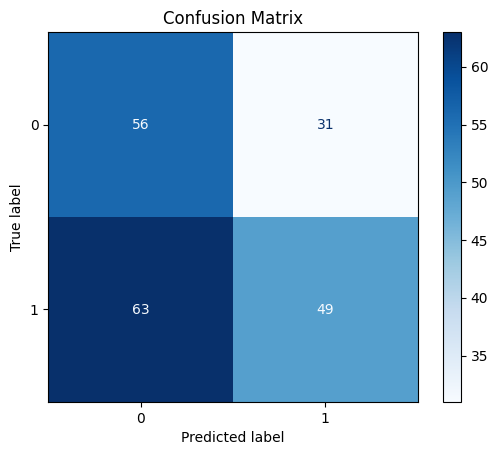

In [145]:
num_labels = 2 
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.to(device)
train_model(model, train_loader, val_loader, epochs=3)
preds, labels = test_model(model, test_loader, 'bert.png')